# <u> SOLVING HOMELESSNESS </u>




- in this project, we aim to solve the current shelter allocation problem for the city of Toronto. In particular We aim to solve this problem by

1. Predicting the amount of homeless people per region

2. Using LP's to optimize shelter allocation such that we:
    - Minimize distance travelled to each shelter
    - Respect each shetlers individual shelter constraints

3. After determiining optimal allocation subject to constraints, we will then do further analysis such as:
    - What are the binding constraints + what they mean 
    - What if analysis: optimal locaiton to  add additional shelter

In [1]:
# open virual environment 
# python -m venv venv
# .\venv\Scripts\Activate

# import the necessary packages

import pandas as pd 
import numpy as np 
import geopandas as gpd
from geopy.geocoders import Nominatim

from geopy.extra.rate_limiter import RateLimiter
from shapely.geometry import Point



# Cleaning + Re-scoping

In [2]:
# the first dataset we will look at + clean will be the shelter_overnight dataset
# in particular we wll define the scope here as
# only in 2024
# only in the city of toronto
# only for the sectors MEN and WOMEN 

shelter_overnight_df = pd.read_csv(r"C:\Users\ahmed\IA2\Datasets\daily-shelter-overnight-service-occupancy-capacity-2024.csv", index_col=0)

for feature in shelter_overnight_df.columns:
    print(f"FEATURE: {feature}")
    print(shelter_overnight_df[feature].unique()[:3])





FEATURE: OCCUPANCY_DATE
['2024-01-01' '2024-01-02' '2024-01-03']
FEATURE: ORGANIZATION_ID
[24 14 23]
FEATURE: ORGANIZATION_NAME
['COSTI Immigrant Services' 'Christie Ossington Neighbourhood Centre'
 'Christie Refugee Welcome Centre, Inc.']
FEATURE: SHELTER_ID
[40 22 39]
FEATURE: SHELTER_GROUP
['COSTI Reception Centre' "Christie Ossington Men's Hostel"
 'Christie Refugee Welcome Centre']
FEATURE: LOCATION_ID
[1320. 1051. 1114.]
FEATURE: LOCATION_NAME
['COSTI Hotel Program Dixon' 'COSTI Reception Centre'
 'COSTI Uptown Hotel Program']
FEATURE: LOCATION_ADDRESS
['640 Dixon Rd.' '100 Lippincott St' '55 Hallcrown Pl']
FEATURE: LOCATION_POSTAL_CODE
['M9W 1J1' 'M5S 2P1' 'M2J 4R1']
FEATURE: LOCATION_CITY
['Toronto' 'North York' 'Etobicoke']
FEATURE: LOCATION_PROVINCE
['ON' nan]
FEATURE: PROGRAM_ID
[16892 16891 12251]
FEATURE: PROGRAM_NAME
['COSTI - Hotel Program - Dixon (Refugee Families)'
 'COSTI - Hotel Program - Dixon (Refugee Singles)'
 'COSTI Reception Centre CITY Program']
FEATURE: SECTO

In [198]:
# we need 
# LOCATION_CITY = 'Toronto'
# SECTOR = ['Men' 'Women']


filter_shelter = shelter_overnight_df.copy()

filter_shelter = filter_shelter[ (filter_shelter['LOCATION_CITY']=='Toronto') & (((filter_shelter['SECTOR']=='Men') | (filter_shelter['SECTOR']=='Women')))]

#for col in filter_shelter.columns:
    #print(col)

print(len(list(filter_shelter['PROGRAM_ID'])))
print(filter_shelter['PROGRAM_ID'].nunique())

unique_program_id = filter_shelter['PROGRAM_ID'].unique()

newy_shelter = filter_shelter.drop_duplicates(subset=['PROGRAM_ID'])

newy_shelter





18233
55


,OCCUPANCY_DATE,ORGANIZATION_ID,ORGANIZATION_NAME,SHELTER_ID,SHELTER_GROUP,LOCATION_ID,LOCATION_NAME,LOCATION_ADDRESS,LOCATION_POSTAL_CODE,LOCATION_CITY,...,OCCUPIED_BEDS,UNOCCUPIED_BEDS,UNAVAILABLE_BEDS,CAPACITY_ACTUAL_ROOM,CAPACITY_FUNDING_ROOM,OCCUPIED_ROOMS,UNOCCUPIED_ROOMS,UNAVAILABLE_ROOMS,OCCUPANCY_RATE_BEDS,OCCUPANCY_RATE_ROOMS
_id,,,,,,,,,,,,,,,,,,,,,
7,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1172.0,CONC West End Hotel Program,14 Roncesvalles Ave,M6R 2K3,Toronto,...,NaN,NaN,NaN,39.0,41.0,39.0,0.0,2.0,NaN,100.0
8,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1029.0,CONC Men's Shelter Lansdowne Ave,973 Lansdowne Ave,M6H 3Z5,Toronto,...,42.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.00,NaN
9,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1102.0,CONC Men's Shelter Bloor St W,850 Bloor St W,M6G 1M2,Toronto,...,30.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.00,NaN
14,2024-01-01,1,City of Toronto,60,Downsview Dells,1009.0,TSSS Downsview Dells,1651 Sheppard Ave W,M3M 2X4,Toronto,...,14.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,77.78,NaN
19,2024-01-01,1,City of Toronto,62,Fort York Residence,1011.0,TSSS Fort York Residence,38 Bathurst St,M5V 3W3,Toronto,...,61.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,89.71,NaN
20,2024-01-01,1,City of Toronto,62,Fort York Residence,1011.0,TSSS Fort York Residence,38 Bathurst St,M5V 3W3,Toronto,...,46.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,95.83,NaN
21,2024-01-01,1,City of Toronto,94,Progress Shelter,1360.0,Progress Avenue Shelter,705 Progress Ave,M1H 2X1,Toronto,...,101.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.00,NaN
26,2024-01-01,1,City of Toronto,3,Seaton House,1154.0,TSSS Junction Place,731 Runnymede Rd,M6N 3V7,Toronto,...,62.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.00,NaN
27,2024-01-01,1,City of Toronto,3,Seaton House,1008.0,TSSS Seaton House,339 George St,M5A 2N2,Toronto,...,66.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,100.00,NaN


| **Feature**              | **Meaning / Description**                          | **Type**          | **Example Values**                                                    |
| ------------------------ | -------------------------------------------------- | ----------------- | --------------------------------------------------------------------- |
| `OCCUPANCY_DATE`         | Date of the overnight shelter record               | string / datetime | '2024-01-01', '2024-01-02', '2024-01-03'                              |
| `ORGANIZATION_ID`        | Unique ID for the organization running the shelter | int               | 24, 14, 23                                                            |
| `ORGANIZATION_NAME`      | Name of the organization                           | string            | 'COSTI Immigrant Services', 'Christie Ossington Neighbourhood Centre' |
| `SHELTER_ID`             | Unique ID for the shelter                          | int               | 40, 22, 39                                                            |
| `SHELTER_GROUP`          | Group / category of the shelter                    | string            | 'COSTI Reception Centre', "Christie Ossington Men's Hostel"           |
| `LOCATION_ID`            | Unique ID for the physical location                | float             | 1320, 1051, 1114                                                      |
| `LOCATION_NAME`          | Name of the shelter location                       | string            | 'COSTI Hotel Program Dixon', 'COSTI Reception Centre'                 |
| `LOCATION_ADDRESS`       | Street address of the shelter                      | string            | '640 Dixon Rd.', '100 Lippincott St'                                  |
| `LOCATION_POSTAL_CODE`   | Postal code                                        | string            | 'M9W 1J1', 'M5S 2P1'                                                  |
| `LOCATION_CITY`          | City or neighborhood                               | string            | 'Toronto', 'North York', 'Etobicoke'                                  |
| `LOCATION_PROVINCE`      | Province                                           | string            | 'ON', nan                                                             |
| `PROGRAM_ID`             | Unique ID for the shelter program                  | int               | 16892, 16891, 12251                                                   |
| `PROGRAM_NAME`           | Name of the program                                | string            | 'COSTI - Hotel Program - Dixon (Refugee Families)'                    |
| `SECTOR`                 | Target population for the program                  | string            | 'Families', 'Mixed Adult', 'Men'                                      |
| `PROGRAM_MODEL`          | Type of shelter program                            | string            | 'Emergency', 'Transitional'                                           |
| `OVERNIGHT_SERVICE_TYPE` | Type of service (shelter type)                     | string            | 'Motel/Hotel Shelter', 'Shelter', 'Warming Centre'                    |
| `PROGRAM_AREA`           | Broad program classification                       | string            | 'Temporary Refugee Response', 'Base Program - Refugee'                |
| `SERVICE_USER_COUNT`     | Number of clients served on that date              | int               | 650, 113, 8                                                           |
| `CAPACITY_TYPE`          | Capacity measured by beds or rooms                 | string            | 'Room Based Capacity', 'Bed Based Capacity'                           |
| `CAPACITY_ACTUAL_BED`    | Actual number of beds available                    | float             | nan, 8, 42                                                            |
| `CAPACITY_FUNDING_BED`   | Number of beds funded                              | float             | nan, 8, 42                                                            |
| `OCCUPIED_BEDS`          | Number of beds occupied                            | float             | nan, 8, 42                                                            |
| `UNOCCUPIED_BEDS`        | Number of beds unoccupied                          | float             | nan, 0, 4                                                             |
| `UNAVAILABLE_BEDS`       | Beds not available                                 | float             | nan, 0, 2                                                             |
| `CAPACITY_ACTUAL_ROOM`   | Actual number of rooms available                   | float             | 149, 57, nan                                                          |
| `CAPACITY_FUNDING_ROOM`  | Number of rooms funded                             | float             | 150, 57, nan                                                          |
| `OCCUPIED_ROOMS`         | Number of rooms occupied                           | float             | 149, 57, nan                                                          |
| `UNOCCUPIED_ROOMS`       | Rooms not occupied                                 | float             | 0, nan, 1                                                             |
| `UNAVAILABLE_ROOMS`      | Rooms not available                                | float             | 1, 0, nan                                                             |
| `OCCUPANCY_RATE_BEDS`    | Percent of beds occupied                           | float             | nan, 100, 82.61                                                       |
| `OCCUPANCY_RATE_ROOMS`   | Percent of rooms occupied                          | float             | 100, nan, 90                                                          |


# IMPORTANT FEATURES

1) SHELTER_ADDRESS: used to locate shelter in map 
2) SHELTER_ID: helps uiquly identify shltesf
3) LOCATION_CITY: 
4) SECTOR: find shlters for men, women, etc
5) SERVICE_COUNT: Number of people visiting an individual shelter per program, per shelter, per day  -> this helps us bun the bed or room contraints
6) 


In [4]:
# we will et total nmber of indivudual Men and Women Shelters

shelters_count = filter_shelter.groupby('SECTOR')['LOCATION_NAME'].nunique().reset_index()
shelters_count.rename(columns={'LOCATION_NAME':'num_shelters'}, inplace=True)

shelters_count


,SECTOR,num_shelters
0,Men,24
1,Women,18


In [ ]:
filter_shelter[ (filter_shelter['SECTOR'] == 'Men') & (filter_shelter['SECTOR']=='Women')]

In [5]:
# Step 1: Filter Toronto shelters for Men or Women
toronto_shelters = shelter_overnight_df[
    (shelter_overnight_df['LOCATION_CITY'] == 'Toronto') &
    (shelter_overnight_df['SECTOR'].isin(['Men', 'Women']))
]

# Step 2: Group by shelter ID and collect all sectors per shelter
shelter_sectors = toronto_shelters.groupby('SHELTER_ID')['SECTOR'].unique().reset_index()

# Step 3: Classify shelters
def classify(sectors):
    if set(sectors) == {'Men'}:
        return 'Men only'
    elif set(sectors) == {'Women'}:
        return 'Women only'
    else:
        return 'Both'

shelter_sectors['type'] = shelter_sectors['SECTOR'].apply(classify)

# Step 4: Count shelters by type
counts = shelter_sectors['type'].value_counts()
print(counts)

all_shell = counts.sum()
print(f"the total number of shleters we are looking at is {all_shell}")

# FROM THIS we obsesve that some shtlers are double ocutned above in name, this is a result of certain shlering ofering multiple programs 
# therefore after going by shelter id, we find the true nubmer

type
Men only      14
Women only    13
Both           2
Name: count, dtype: int64
the total number of shleters we are looking at is 29


In [6]:

## ROOM BASED ANALYSYS: in here we uncover the number of people that can be alotted for room based shelters


# Step 1: Filter room-based shelters in Toronto for Men/Women
room_based = filter_shelter[filter_shelter['CAPACITY_TYPE'] == 'Room Based Capacity'].copy()

# Step 2: Compute max people and max rooms per shelter
shelter_stats = room_based.groupby([ 'LOCATION_CITY', 'SECTOR', 'SHELTER_ID', 'LOCATION_ADDRESS']).agg(max_people_served=('SERVICE_USER_COUNT', 'max'), max_rooms_occupied=('OCCUPIED_ROOMS', 'max')).reset_index()

# Step 3: Calculate average people per room per shelter (using max values)
shelter_stats['avg_people_per_room'] = shelter_stats['max_people_served'] / shelter_stats['max_rooms_occupied']


## additoinaly, as a snaity, I will check the number of bed vs 

# Step 4: Display
shelter_stats




,LOCATION_CITY,SECTOR,SHELTER_ID,LOCATION_ADDRESS,max_people_served,max_rooms_occupied,avg_people_per_room
0,Toronto,Men,16,335 Jarvis St,47,47.0,1.000000
1,Toronto,Men,22,14 Roncesvalles Ave,40,40.0,1.000000
2,Toronto,Men,30,556 Sherbourne St,31,31.0,1.000000
3,Toronto,Women,36,26 Gerrard St E,47,33.0,1.424242


In [7]:
# Step 1: Use filtered Toronto Men/Women shelters
# filter_shelter already has Toronto & SECTOR in ['Men','Women']

# Step 2: Group by shelter ID and get unique capacity types per shelter
shelter_capacity = filter_shelter.groupby('SHELTER_ID')['CAPACITY_TYPE'].unique().reset_index()

# Step 3: Count number of shelters by capacity type
def classify_capacity(cap_types):
    if len(cap_types) == 1:
        return cap_types[0]  # Bed Based or Room Based
    else:
        return 'Both'        # Shelter has programs with both capacity types

shelter_capacity['type'] = shelter_capacity['CAPACITY_TYPE'].apply(classify_capacity)

# Step 4: Count shelters per type
capacity_counts = shelter_capacity['type'].value_counts()
print(capacity_counts)


type
Bed Based Capacity     25
Both                    3
Room Based Capacity     1
Name: count, dtype: int64


from the above snippet we have determined a few important facts

1) A individual shelter, marked by a unique SHELTER_ID can be associated with multiple programs allowing it to serve multiple SECTORS as well as alternate between ROOM vs BED based measurments
2) We track the number of daily visistors using SERVICE_USER_COUNT, which falls into 2 cases
    - bed based: SERVICE_USER_COUNT == BED_BASED_OCCUPIED
    - room based: SERVICE_USER_COUNT != ROOM_BASED_OCCUPIED

however from shelter_stats, we observe that for all shelters EXCEPT 26 Gerrard St E	 Womens shelter, each person is assigned to one room


C:\Users\ahmed\AppData\Local\Temp\ipykernel_22352\1726316438.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shelter_sector_occupancy = toronto_mw.groupby(['SHELTER_ID','SECTOR']).apply(lambda x: x['occupancy_rate'].mean()).reset_index(name='occupancy_rate')


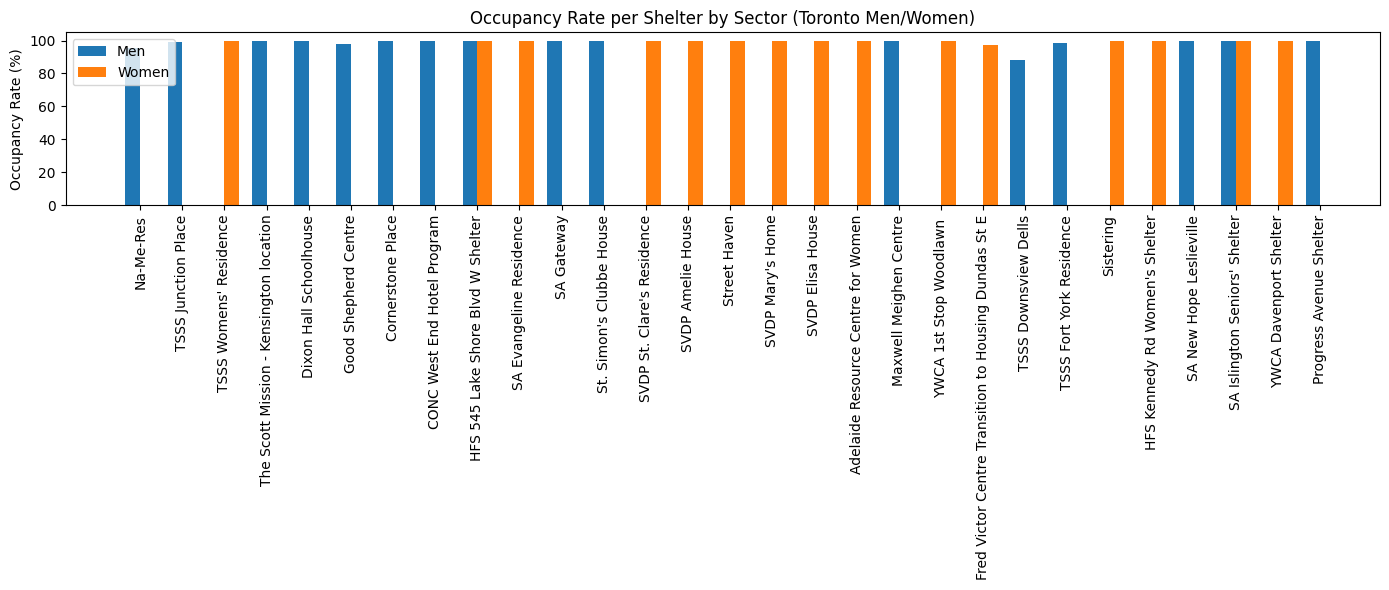

In [8]:
## PLOT THE OCCUPANCY RATE BED OR OCCPANCY RATE ROOMS FOR EACH


import matplotlib.pyplot as plt
import numpy as np

# Step 1: Filter Toronto Men/Women shelters (you already have filter_shelter)
toronto_mw = filter_shelter.copy()

# Step 2: Pick occupancy rate per row depending on capacity type
def get_occupancy(row):
    if row['CAPACITY_TYPE'] == 'Bed Based Capacity':
        return row['OCCUPANCY_RATE_BEDS']
    elif row['CAPACITY_TYPE'] == 'Room Based Capacity':
        return row['OCCUPANCY_RATE_ROOMS']
    else:  # Both
        return row['OCCUPANCY_RATE_BEDS'] if not np.isnan(row['OCCUPANCY_RATE_BEDS']) else row['OCCUPANCY_RATE_ROOMS']

toronto_mw['occupancy_rate'] = toronto_mw.apply(get_occupancy, axis=1)

# Step 3: Group by SHELTER_ID, SECTOR and get representative occupancy (mean or first)
shelter_sector_occupancy = toronto_mw.groupby(['SHELTER_ID','SECTOR']).apply(lambda x: x['occupancy_rate'].mean()).reset_index(name='occupancy_rate')

# Step 4: Plot side by side
shelters = shelter_sector_occupancy['SHELTER_ID'].unique()
x = np.arange(len(shelters))  
width = 0.35  # bar width

men_occ = shelter_sector_occupancy[shelter_sector_occupancy['SECTOR']=='Men'].set_index('SHELTER_ID').reindex(shelters)['occupancy_rate']
women_occ = shelter_sector_occupancy[shelter_sector_occupancy['SECTOR']=='Women'].set_index('SHELTER_ID').reindex(shelters)['occupancy_rate']

plt.figure(figsize=(14,6))
plt.bar(x - width/2, men_occ, width, label='Men')
plt.bar(x + width/2, women_occ, width, label='Women')
plt.xticks(x, [toronto_mw[toronto_mw['SHELTER_ID']==sid]['LOCATION_NAME'].iloc[0] for sid in shelters], rotation=90)
plt.ylabel("Occupancy Rate (%)")
plt.title("Occupancy Rate per Shelter by Sector (Toronto Men/Women)")
plt.legend()
plt.tight_layout()
plt.show()




In [9]:
men_df = pd.DataFrame(men_occ)
men_df.sort_values(ascending=True, by='occupancy_rate')




,occupancy_rate
SHELTER_ID,
60,87.981257
1,95.767090
16,97.713471
62,98.567049
3,98.838711
22,99.939912
45,99.948087
77,99.958497
94,99.959399


In [10]:
women_df = pd.DataFrame(women_occ)
women_df.sort_values(ascending=True, by='occupancy_rate')




,occupancy_rate
SHELTER_ID,
58,97.065505
42,99.556694
65,99.607240
78,99.882951
24,99.943005
50,99.946776
34,99.954426
77,99.955738
4,99.956230


In [11]:
# Step 1: Filter Toronto shelters for Men or Women
toronto_shelters = filter_shelter[
    (filter_shelter['LOCATION_CITY'] == 'Toronto') &
    (filter_shelter['SECTOR'].isin(['Men', 'Women']))
]

# Step 2: Group by shelter ID and collect all sectors per shelter
shelter_sectors = toronto_shelters.groupby('SHELTER_ID')['SECTOR'].unique().reset_index()

# Step 3: Classify shelters
def classify(sectors):
    sectors_set = set(sectors)
    if sectors_set == {'Men'}:
        return 'Men only'
    elif sectors_set == {'Women'}:
        return 'Women only'
    else:
        return 'Both'

shelter_sectors['type'] = shelter_sectors['SECTOR'].apply(classify)

# Step 4: Inspect
shelter_sectors



,SHELTER_ID,SECTOR,type
0,1,[Men],Men only
1,3,[Men],Men only
2,4,[Women],Women only
3,8,[Men],Men only
4,14,[Men],Men only
5,16,[Men],Men only
6,21,[Men],Men only
7,22,[Men],Men only
8,24,"[Men, Women]",Both
9,28,[Women],Women only


In [199]:
newy_shelter = newy_shelter[(newy_shelter['LOCATION_CITY']=='Toronto') & newy_shelter['SECTOR'].isin(['Men', 'Women'])].copy()

newy_shelter['full_address'] = newy_shelter['LOCATION_ADDRESS'] + ", " + \
                                  newy_shelter['LOCATION_CITY'] + ", " + \
                                  newy_shelter['LOCATION_PROVINCE']

geolocator = Nominatim(user_agent="toronto_shelters_app")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def safe_geocode(address):
    try:
        return geocode(address, timeout=10)
    except Exception as e:
        print(f"Failed to geocode {address}: {e}")
        return None

newy_shelter['location'] = newy_shelter['full_address'].apply(safe_geocode)


newy_shelter['latitude'] = newy_shelter['location'].apply(lambda loc: loc.latitude if loc else None)
newy_shelter['longitude'] = newy_shelter['location'].apply(lambda loc: loc.longitude if loc else None)

def classify(sectors):
    s = set(sectors)
    if s == {'Men'}:
        return 'Men only'
    elif s == {'Women'}:
        return 'Women only'
    else:
        return 'Both'
    
    
newy_shelter['type'] = newy_shelter['SECTOR'].apply(classify)



In [201]:
newy_shelter

,OCCUPANCY_DATE,ORGANIZATION_ID,ORGANIZATION_NAME,SHELTER_ID,SHELTER_GROUP,LOCATION_ID,LOCATION_NAME,LOCATION_ADDRESS,LOCATION_POSTAL_CODE,LOCATION_CITY,...,OCCUPIED_ROOMS,UNOCCUPIED_ROOMS,UNAVAILABLE_ROOMS,OCCUPANCY_RATE_BEDS,OCCUPANCY_RATE_ROOMS,full_address,location,latitude,longitude,type
_id,,,,,,,,,,,,,,,,,,,,,
7,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1172.0,CONC West End Hotel Program,14 Roncesvalles Ave,M6R 2K3,Toronto,...,39.0,0.0,2.0,NaN,100.0,"14 Roncesvalles Ave, Toronto, ON","(14, Roncesvalles Avenue, Roncesvalles, Sunnys...",43.639019,-79.446514,Both
8,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1029.0,CONC Men's Shelter Lansdowne Ave,973 Lansdowne Ave,M6H 3Z5,Toronto,...,NaN,NaN,NaN,100.00,NaN,"973 Lansdowne Ave, Toronto, ON","(973, Lansdowne Avenue, Wallace Emerson, Daven...",43.666098,-79.446011,Both
9,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1102.0,CONC Men's Shelter Bloor St W,850 Bloor St W,M6G 1M2,Toronto,...,NaN,NaN,NaN,100.00,NaN,"850 Bloor St W, Toronto, ON","(850, Bloor Street West, Dovercourt Village, U...",43.662443,-79.424144,Both
14,2024-01-01,1,City of Toronto,60,Downsview Dells,1009.0,TSSS Downsview Dells,1651 Sheppard Ave W,M3M 2X4,Toronto,...,NaN,NaN,NaN,77.78,NaN,"1651 Sheppard Ave W, Toronto, ON","(1651, Sheppard Avenue West, Downsview, York C...",43.742472,-79.496554,Both
19,2024-01-01,1,City of Toronto,62,Fort York Residence,1011.0,TSSS Fort York Residence,38 Bathurst St,M5V 3W3,Toronto,...,NaN,NaN,NaN,89.71,NaN,"38 Bathurst St, Toronto, ON","(38, Bathurst Street, Wellington Place, Spadin...",43.641817,-79.401972,Both
20,2024-01-01,1,City of Toronto,62,Fort York Residence,1011.0,TSSS Fort York Residence,38 Bathurst St,M5V 3W3,Toronto,...,NaN,NaN,NaN,95.83,NaN,"38 Bathurst St, Toronto, ON","(38, Bathurst Street, Wellington Place, Spadin...",43.641817,-79.401972,Both
21,2024-01-01,1,City of Toronto,94,Progress Shelter,1360.0,Progress Avenue Shelter,705 Progress Ave,M1H 2X1,Toronto,...,NaN,NaN,NaN,100.00,NaN,"705 Progress Ave, Toronto, ON","(705, Progress Avenue, Woburn North, Scarborou...",43.778314,-79.246465,Both
26,2024-01-01,1,City of Toronto,3,Seaton House,1154.0,TSSS Junction Place,731 Runnymede Rd,M6N 3V7,Toronto,...,NaN,NaN,NaN,100.00,NaN,"731 Runnymede Rd, Toronto, ON","(731, Runnymede Road, Junction Area, York Sout...",43.668090,-79.482960,Both
27,2024-01-01,1,City of Toronto,3,Seaton House,1008.0,TSSS Seaton House,339 George St,M5A 2N2,Toronto,...,NaN,NaN,NaN,100.00,NaN,"339 George St, Toronto, ON","(339, George Street, Moss Park, Toronto Centre...",43.659700,-79.374323,Both


In [193]:
# Filter Toronto shelters for Men or Women
toronto_shelters = filter_shelter[
    (filter_shelter['LOCATION_CITY'] == 'Toronto') & 
    (filter_shelter['SECTOR'].isin(['Men', 'Women']))
].copy()

# Step 1: Get unique shelters and combine sectors per shelter
unique_shelters = toronto_shelters.groupby('SHELTER_ID').agg({
    'LOCATION_NAME': 'first',
    'LOCATION_ADDRESS': 'first',
    'LOCATION_CITY': 'first',
    'LOCATION_PROVINCE': 'first',
    'SECTOR': lambda x: list(set(x)),  # combine all unique sectors
    'CAPACITY_TYPE': 'first'
}).reset_index()

# Step 2: Create full address
unique_shelters['full_address'] = unique_shelters['LOCATION_ADDRESS'] + ", " + \
                                  unique_shelters['LOCATION_CITY'] + ", " + \
                                  unique_shelters['LOCATION_PROVINCE']

# Step 3: Initialize geolocator
geolocator = Nominatim(user_agent="toronto_shelters_app")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Step 4: Apply geocode safely
def safe_geocode(address):
    try:
        return geocode(address, timeout=10)
    except Exception as e:
        print(f"Failed to geocode {address}: {e}")
        return None

unique_shelters['location'] = unique_shelters['full_address'].apply(safe_geocode)

# Step 5: Extract latitude and longitude
unique_shelters['latitude'] = unique_shelters['location'].apply(lambda loc: loc.latitude if loc else None)
unique_shelters['longitude'] = unique_shelters['location'].apply(lambda loc: loc.longitude if loc else None)

# Step 6: Classify shelters by sector
def classify(sectors):
    s = set(sectors)
    if s == {'Men'}:
        return 'Men only'
    elif s == {'Women'}:
        return 'Women only'
    else:
        return 'Both'

unique_shelters['type'] = unique_shelters['SECTOR'].apply(classify)

# Step 7: Inspect the resulting DataFrame
unique_shelters




KeyboardInterrupt: 

In [13]:
unique_shelters.to_csv("toronto_shelters_coords.csv", index=False)

In [202]:
newy_shelter.to_csv('unique_programname_coords.csv', index=False)

In [14]:
import folium

# Center the map roughly around Toronto
map_toronto = folium.Map(location=[43.7, -79.4], zoom_start=11)

# Define colors for each type
colors = {
    'Men only': 'blue',
    'Women only': 'red',
    'Both': 'purple'
}

# Add each shelter as a CircleMarker with popup
for idx, row in unique_shelters.iterrows():
    if pd.notnull(row['latitude']) and pd.notnull(row['longitude']):
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=7,
            color=colors[row['type']],
            fill=True,
            fill_color=colors[row['type']],
            fill_opacity=0.7,
            popup=folium.Popup(
                html=(
                    f"<b>{row['LOCATION_NAME']}</b><br>"
                    f"Type: {row['type']}<br>"
                    f"Address: {row['LOCATION_ADDRESS']}<br>"
                    f"Capacity type: {', '.join(row['CAPACITY_TYPE']) if isinstance(row['CAPACITY_TYPE'], list) else row['CAPACITY_TYPE']}"
                ),
                max_width=300
            )
        ).add_to(map_toronto)

# Optional: Add a legend
legend_html = """
 <div style="position: fixed; 
             bottom: 50px; left: 50px; width: 150px; height: 110px; 
             border:2px solid grey; z-index:9999; font-size:14px;
             background-color:white; padding: 10px;">
 <b>Shelter Type</b><br>
 <i class="fa fa-circle" style="color:blue"></i> Men only<br>
 <i class="fa fa-circle" style="color:red"></i> Women only<br>
 <i class="fa fa-circle" style="color:purple"></i> Both
 </div>
"""
map_toronto.get_root().html.add_child(folium.Element(legend_html))

# Display map
#map_toronto
map_toronto.save("toronto_map.html")


## We will now be dropping all the ppor people neighbourhooods!


1) We will be lookng at the neigbourhood profiles dataset and looking for the releavnt rows to get COUNTS
2) using these coutns we will INSHALLAH create a heatmap and the centroids



In [131]:
fwd_info_df = pd.read_csv(r'C:\Users\ahmed\IA2\Datasets\98-401-X2021013_eng_CSV_FWD\98-401-X2021013_English_CSV_data.csv', encoding="latin1")

fwd_info_df.head()


for uniq_char in fwd_info_df['CHARACTERISTIC_NAME'].unique():
    print(uniq_char)

Population, 2021
Population, 2016
Population percentage change, 2016 to 2021
Total private dwellings
Private dwellings occupied by usual residents
Population density per square kilometre
Land area in square kilometres
Total - Age groups of the population - 100% data
  0 to 14 years
    0 to 4 years
    5 to 9 years
    10 to 14 years
  15 to 64 years
    15 to 19 years
    20 to 24 years
    25 to 29 years
    30 to 34 years
    35 to 39 years
    40 to 44 years
    45 to 49 years
    50 to 54 years
    55 to 59 years
    60 to 64 years
  65 years and over
    65 to 69 years
    70 to 74 years
    75 to 79 years
    80 to 84 years
    85 years and over
      85 to 89 years
      90 to 94 years
      95 to 99 years
      100 years and over
Total - Distribution (%) of the population by broad age groups - 100% data
Average age of the population
Median age of the population
Total - Occupied private dwellings by structural type of dwelling - 100% data
  Single-detached house
  Semi-detached

In [181]:
fwd_info_df

,CENSUS_YEAR,DGUID,ALT_GEO_CODE,GEO_LEVEL,GEO_NAME,TNR_SF,TNR_LF,DATA_QUALITY_FLAG,CHARACTERISTIC_ID,CHARACTERISTIC_NAME,...,C2_COUNT_MEN+,SYMBOL.1,C3_COUNT_WOMEN+,SYMBOL.2,C10_RATE_TOTAL,SYMBOL.3,C11_RATE_MEN+,SYMBOL.4,C12_RATE_WOMEN+,SYMBOL.5
0,2021,2021A0011A0A,A0A,Forward sortation area,A0A,3.3,4.2,0,1,"Population, 2021",...,NaN,...,NaN,...,NaN,...,NaN,...,NaN,...
1,2021,2021A0011A0A,A0A,Forward sortation area,A0A,3.3,4.2,0,2,"Population, 2016",...,NaN,...,NaN,...,NaN,...,NaN,...,NaN,...
2,2021,2021A0011A0A,A0A,Forward sortation area,A0A,3.3,4.2,0,3,"Population percentage change, 2016 to 2021",...,NaN,...,NaN,...,NaN,...,NaN,...,NaN,...
3,2021,2021A0011A0A,A0A,Forward sortation area,A0A,3.3,4.2,0,4,Total private dwellings,...,NaN,...,NaN,...,NaN,...,NaN,...,NaN,...
4,2021,2021A0011A0A,A0A,Forward sortation area,A0A,3.3,4.2,0,5,Private dwellings occupied by usual residents,...,NaN,...,NaN,...,NaN,...,NaN,...,NaN,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4330621,2021,2021A0011Y1A,Y1A,Forward sortation area,Y1A,2.8,7.0,0,2627,Total - Eligibility and instruction in the min...,...,2450.0,NaN,2185.0,NaN,100.0,NaN,100.0,NaN,100.0,NaN
4330622,2021,2021A0011Y1A,Y1A,Forward sortation area,Y1A,2.8,7.0,0,2628,Children eligible for instruction in the min...,...,370.0,NaN,320.0,NaN,14.9,NaN,15.1,NaN,14.6,NaN
4330623,2021,2021A0011Y1A,Y1A,Forward sortation area,Y1A,2.8,7.0,0,2629,Eligible children who have been instructed...,...,270.0,NaN,250.0,NaN,11.3,NaN,11.0,NaN,11.4,NaN
4330624,2021,2021A0011Y1A,Y1A,Forward sortation area,Y1A,2.8,7.0,0,2630,Eligible children who have not been instru...,...,100.0,NaN,65.0,NaN,3.6,NaN,4.1,NaN,3.0,NaN


In [ ]:

"""
mans looked at the dataset and picked 3 features, most of them have to do with meidan income but we chose LIM -> low income
^ important to note htt we get COUNTS for numbeer of people in each FWD stsafying charactersitc/feature 
"""


low_income_features = [
    "In low income based on the Low-income measure, after tax (LIM-AT)",
    "Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)",
    "Median after-tax income in 2020 among recipients ($)"]



low_income_df = fwd_info_df[fwd_info_df['CHARACTERISTIC_NAME'].isin(low_income_features)].copy()

low_income_df = low_income_df.reset_index(drop=True)



In [133]:
# Filter FSAs in Toronto (first letter "M")
toronto_fsa_df = low_income_df[low_income_df['GEO_NAME'].str.startswith("M")].copy()
toronto_fsa_df = toronto_fsa_df.reset_index(drop=True)



toronto_fsa_pivot = toronto_fsa_df.pivot_table(
    index='GEO_NAME',
    columns='CHARACTERISTIC_NAME',
    values='C1_COUNT_TOTAL'     
).reset_index()





from geopy.geocoders import Nominatim


geolocator = Nominatim(user_agent="toronto_fsa_geocoder")

def get_fsa_latlon(fsa_code):
    try:
        location = geolocator.geocode(f"Forward Sortation Area {fsa_code}, Toronto, Ontario, Canada")

        if location:
            return pd.Series([location.latitude, location.longitude])
        else:
            return pd.Series([None, None])
    except:
        return pd.Series([None, None])


toronto_fsa_pivot




CHARACTERISTIC_NAME,GEO_NAME,"In low income based on the Low-income measure, after tax (LIM-AT)","Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)"
0,M1B,6255.0,9.6
1,M1C,1910.0,5.4
2,M1E,6215.0,13.1
3,M1G,5390.0,17.5
4,M1H,3085.0,13.0
...,...,...,...
91,M9N,4175.0,16.2
92,M9P,2230.0,11.0
93,M9R,4150.0,12.3
94,M9V,6995.0,13.1


In [134]:
import geopandas as gpd

# Make sure to use a raw string (r"") or double backslashes \\ for Windows paths
shapefile_path = r"C:\Users\ahmed\IA2\lfsa000a16a_e\lfsa000a16a_e.shp"

# Load shapefile into a GeoDataFrame
geoframe = gpd.read_file(shapefile_path)

tfsa = geoframe[geoframe['CFSAUID'].str.startswith('M')].copy()

# Check first few rows
tfsa

,CFSAUID,PRUID,PRNAME,geometry
637,M9R,35,Ontario,"POLYGON ((7209908.14 928259.897, 7209816.766 9..."
638,M9V,35,Ontario,"POLYGON ((7206682.694 937743.451, 7206631.563 ..."
639,M9W,35,Ontario,"POLYGON ((7210531.76 934710.503, 7210542.117 9..."
701,M1P,35,Ontario,"POLYGON ((7233594.731 942118.174, 7233584.157 ..."
702,M1R,35,Ontario,"MULTIPOLYGON (((7231166.76 939882.914, 7231356..."
...,...,...,...,...
1226,M6M,35,Ontario,"POLYGON ((7216847.5 932886, 7216992.186 932544..."
1227,M6N,35,Ontario,"POLYGON ((7215682 930856.563, 7215994.5 930725..."
1228,M6P,35,Ontario,"POLYGON ((7219671.957 928249.763, 7219688.191 ..."
1244,M5P,35,Ontario,"POLYGON ((7222813.203 933279.526, 7222831.411 ..."


In [135]:
tfsa['centroid'] = tfsa.geometry.centroid
tfsa['Latitude'] = tfsa.centroid.y
tfsa['Longitude'] = tfsa.centroid.x

tfsa_coords = tfsa[['CFSAUID', 'Latitude', 'Longitude']].copy()

toronto_fsa_final = toronto_fsa_pivot.merge(
    tfsa_coords,
    left_on='GEO_NAME',
    right_on='CFSAUID',
    how='left'
)

toronto_fsa_final



,GEO_NAME,"In low income based on the Low-income measure, after tax (LIM-AT)","Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)",CFSAUID,Latitude,Longitude
0,M1B,6255.0,9.6,M1B,950250.812755,7.236607e+06
1,M1C,1910.0,5.4,M1C,947385.894140,7.240264e+06
2,M1E,6215.0,13.1,M1E,944535.176095,7.238296e+06
3,M1G,5390.0,17.5,M1G,944698.702183,7.235626e+06
4,M1H,3085.0,13.0,M1H,943627.285357,7.233992e+06
...,...,...,...,...,...,...
91,M9N,4175.0,16.2,M9N,932527.195773,7.212706e+06
92,M9P,2230.0,11.0,M9P,930949.416942,7.211825e+06
93,M9R,4150.0,12.3,M9R,929762.823643,7.209893e+06
94,M9V,6995.0,13.1,M9V,935323.203653,7.205749e+06


In [136]:


# since we have one percentage ans one COUNT, we will use min max scaling to across features then gets weghted scores

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

toronto_fsa_pivot[['low_income_count_scaled', 'low_income_pct_scaled']] = scaler.fit_transform(toronto_fsa_pivot[['In low income based on the Low-income measure, after tax (LIM-AT)', 'Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)']])

toronto_fsa_pivot['low_income_score'] = (0.5 * toronto_fsa_pivot['low_income_count_scaled'] + 0.5 * toronto_fsa_pivot['low_income_pct_scaled'])



toronto_fsa_final = toronto_fsa_pivot.merge(
    tfsa_coords,
    left_on='GEO_NAME',
    right_on='CFSAUID',
    how='left'
)



weighted_fwd = toronto_fsa_final[['GEO_NAME', 'low_income_score']].copy()



In [142]:
tfsa.head(2)

,CFSAUID,PRUID,PRNAME,geometry,centroid,Latitude,Longitude
637,M9R,35,Ontario,"POLYGON ((7209908.14 928259.897, 7209816.766 9...",POINT (7209892.678 929762.824),929762.823643,7.209893e+06
638,M9V,35,Ontario,"POLYGON ((7206682.694 937743.451, 7206631.563 ...",POINT (7205749.383 935323.204),935323.203653,7.205749e+06


In [143]:
weighted_fwd.head(2)

,CFSAUID,low_income_score
0,M1B,0.314583
1,M1C,0.053891


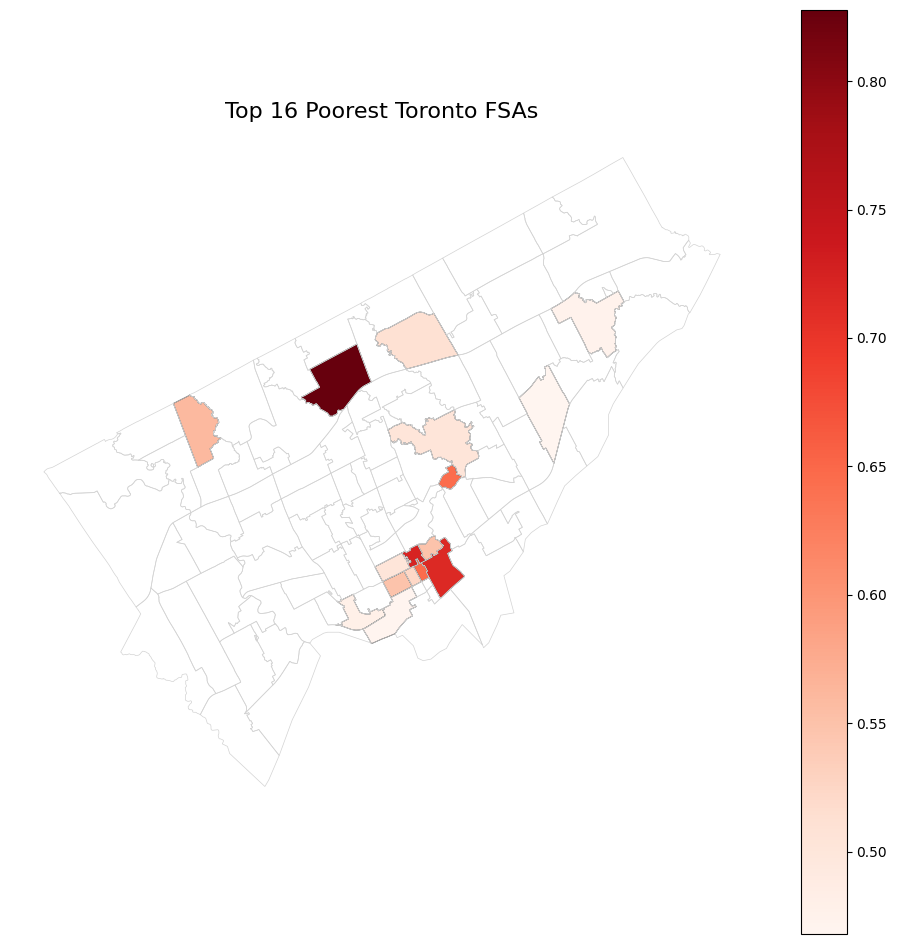

(16, 8)


,CFSAUID,PRUID,PRNAME,geometry,centroid,Latitude,Longitude,low_income_score
5,M2N,35,Ontario,"POLYGON ((7220894.657 939940.674, 7220823.754 ...",POINT (7220043.337 940986.526),940986.526146,7.220043e+06,0.827670
69,M4Y,35,Ontario,"POLYGON ((7225160.217 930461.557, 7225200.626 ...",POINT (7224691.359 930226.081),930226.080649,7.224691e+06,0.723391
75,M5A,35,Ontario,"POLYGON ((7226812.811 930259.597, 7226821.983 ...",POINT (7226445.187 929379.794),929379.793945,7.226445e+06,0.716628
76,M5B,35,Ontario,"POLYGON ((7225030.606 929800.8, 7225040.991 92...",POINT (7225138.866 929310.615),929310.615454,7.225139e+06,0.645232
18,M4H,35,Ontario,"POLYGON ((7227328.523 935234.914, 7227348.94 9...",POINT (7226890.962 935017.041),935017.041160,7.226891e+06,0.643874
47,M3N,35,Ontario,"POLYGON ((7211031.314 940035.191, 7211037.903 ...",POINT (7211417.362 938102.491),938102.490913,7.211417e+06,0.560171
56,M5T,35,Ontario,"POLYGON ((7224198.854 929074.811, 7224265.991 ...",POINT (7223666.223 928508.342),928508.341729,7.223666e+06,0.549059
65,M4X,35,Ontario,"POLYGON ((7226370.031 930977.34, 7226380.726 9...",POINT (7225696.21 930734.156),930734.155755,7.225696e+06,0.548928
79,M5G,35,Ontario,"POLYGON ((7224619.206 928395.289, 7224593.254 ...",POINT (7224610.987 928995.439),928995.439334,7.224611e+06,0.523485
35,M2J,35,Ontario,"POLYGON ((7225596.2 945046.554, 7225615.24 945...",POINT (7224872.112 943453.8),943453.800226,7.224872e+06,0.512407


In [180]:
# Make sure weighted_fwd columns are flat
weighted_fwd.columns = ['CFSAUID', 'low_income_score']

# Ensure CFSAUIDs are strings
weighted_fwd['CFSAUID'] = weighted_fwd['CFSAUID'].astype(str).str.strip().str.upper()
tfsa['CFSAUID'] = tfsa['CFSAUID'].astype(str).str.strip().str.upper()


import matplotlib.pyplot as plt

def plot_top_k_poor_fsas(tfsa, weighted_fwd, k=10, cmap='Reds'):

    
    toronto_fsa_geo = tfsa.merge(weighted_fwd, on='CFSAUID', how='left')

    top_k = toronto_fsa_geo.sort_values(by='low_income_score', ascending=False).iloc[0:k]
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    tfsa.boundary.plot(ax=ax, linewidth=0.5, edgecolor='black', color='lightgray')
    
    top_k.plot(
        column='low_income_score',
        cmap=cmap,
        linewidth=0.5,
        edgecolor='black',
        legend=True,
        ax=ax
    )
    
    ax.set_title(f'Top {k} Poorest Toronto FSAs', fontsize=16)
    ax.axis('off')
    plt.show()
    
    return top_k

top_k_geo = plot_top_k_poor_fsas(tfsa, weighted_fwd, k=16)
print(top_k_geo.shape)
top_k_geo





## WE HAVE SUCCESULLT LOCATIED THE BROKE BOYS

now i wil attempt the impossible and plot the shtelrs locaiton and hosptos against eachother
PRAY

In [203]:




def distance_matrix(type_shelter, top_k_geo):
    """
    Compute distances from each shelter to each FSA centroid.
    
    Parameters:
        type_shelter: pd.DataFrame with columns 'latitude' and 'longitude'
        top_k_geo: pd.DataFrame with columns 'CFSAUID', 'Latitude', 'Longitude'

    Returns:
        pd.DataFrame: distance matrix, shelters as rows, FSAs as columns
    """
    # Extract coordinates
    shelter_coords = type_shelter[['latitude', 'longitude']].to_numpy()
    fsa_coords = top_k_geo[['Latitude', 'Longitude']].to_numpy()
    
    # Initialize distance matrix
    dist_matrix = np.zeros((shelter_coords.shape[0], fsa_coords.shape[0]))
    
    # Compute Euclidean distances (or Haversine if you convert to lat/lon degrees)
    for i, (s_lat, s_lon) in enumerate(shelter_coords):
        dist_matrix[i, :] = np.sqrt((fsa_coords[:, 0] - s_lat)**2 + (fsa_coords[:, 1] - s_lon)**2)
    
    # Convert to DataFrame
    dist_df = pd.DataFrame(
        dist_matrix,
        index=type_shelter['LOCATION_NAME'],
        columns=top_k_geo['CFSAUID']
    )
    
    return dist_df

#mens_shelters = unique_shelters[unique_shelters['SECTOR'].apply(lambda x: 'Men' in x)]
#women_shelters = unique_shelters[unique_shelters['SECTOR'].apply(lambda x: 'Women' in x)]
#mens_dist = distance_matrix(mens_shelters, top_k_geo)
#women_dist = distance_matrix(women_shelters, top_k_geo)
#anyone_dist = distance_matrix(unique_shelters, top_k_geo)


pr0gram_name_dist = distance_matrix(newy_shelter, top_k_geo)



In [176]:
anyone_dist

CFSAUID,M2N,M4Y,M5A,M5B,M4H,M3N,M5T,M4X,M5G,M2J,M5S,M3C,M6K,M1G,M5V,M1K,M1T,M1P,M2M,M1V
LOCATION_NAME,,,,,,,,,,,,,,,,,,,,
Na-Me-Res,7.281178e+06,7.284405e+06,7.286036e+06,7.284732e+06,7.287199e+06,7.272251e+06,7.283169e+06,7.285466e+06,7.284168e+06,7.286285e+06,7.283025e+06,7.286900e+06,7.280556e+06,7.297110e+06,7.282594e+06,7.293632e+06,7.289912e+06,7.292808e+06,7.281037e+06,7.291584e+06
TSSS Junction Place,7.281178e+06,7.284405e+06,7.286036e+06,7.284732e+06,7.287200e+06,7.272251e+06,7.283169e+06,7.285466e+06,7.284168e+06,7.286285e+06,7.283025e+06,7.286900e+06,7.280556e+06,7.297110e+06,7.282594e+06,7.293632e+06,7.289912e+06,7.292808e+06,7.281037e+06,7.291584e+06
TSSS Womens' Residence,7.281178e+06,7.284405e+06,7.286036e+06,7.284732e+06,7.287199e+06,7.272251e+06,7.283169e+06,7.285466e+06,7.284168e+06,7.286285e+06,7.283025e+06,7.286900e+06,7.280556e+06,7.297110e+06,7.282594e+06,7.293632e+06,7.289912e+06,7.292808e+06,7.281037e+06,7.291584e+06
The Scott Mission - Kensington location,7.281178e+06,7.284405e+06,7.286036e+06,7.284732e+06,7.287199e+06,7.272251e+06,7.283169e+06,7.285466e+06,7.284168e+06,7.286285e+06,7.283025e+06,7.286900e+06,7.280556e+06,7.297110e+06,7.282594e+06,7.293632e+06,7.289912e+06,7.292808e+06,7.281037e+06,7.291584e+06
Dixon Hall Schoolhouse,7.281177e+06,7.284405e+06,7.286036e+06,7.284732e+06,7.287199e+06,7.272251e+06,7.283169e+06,7.285466e+06,7.284168e+06,7.286285e+06,7.283025e+06,7.286900e+06,7.280556e+06,7.297110e+06,7.282594e+06,7.293632e+06,7.289912e+06,7.292808e+06,7.281037e+06,7.291584e+06
Good Shepherd Centre,7.281177e+06,7.284405e+06,7.286036e+06,7.284732e+06,7.287199e+06,7.272251e+06,7.283169e+06,7.285466e+06,7.284168e+06,7.286285e+06,7.283025e+06,7.286900e+06,7.280556e+06,7.297110e+06,7.282594e+06,7.293632e+06,7.289912e+06,7.292808e+06,7.281037e+06,7.291584e+06
Cornerstone Place,7.281178e+06,7.284405e+06,7.286036e+06,7.284732e+06,7.287199e+06,7.272251e+06,7.283169e+06,7.285466e+06,7.284168e+06,7.286285e+06,7.283025e+06,7.286900e+06,7.280556e+06,7.297110e+06,7.282594e+06,7.293632e+06,7.289912e+06,7.292808e+06,7.281037e+06,7.291584e+06
CONC West End Hotel Program,7.281178e+06,7.284405e+06,7.286036e+06,7.284732e+06,7.287199e+06,7.272251e+06,7.283169e+06,7.285466e+06,7.284168e+06,7.286285e+06,7.283025e+06,7.286900e+06,7.280556e+06,7.297110e+06,7.282594e+06,7.293632e+06,7.289912e+06,7.292808e+06,7.281037e+06,7.291584e+06
HFS 545 Lake Shore Blvd W Shelter,7.281178e+06,7.284405e+06,7.286036e+06,7.284732e+06,7.287199e+06,7.272251e+06,7.283169e+06,7.285466e+06,7.284168e+06,7.286285e+06,7.283025e+06,7.286900e+06,7.280556e+06,7.297110e+06,7.282594e+06,7.293632e+06,7.289912e+06,7.292808e+06,7.281037e+06,7.291584e+06


In [206]:
pr0gram_name_dist.to_csv('updated_by_shelter_program_distance_matrix.csv')

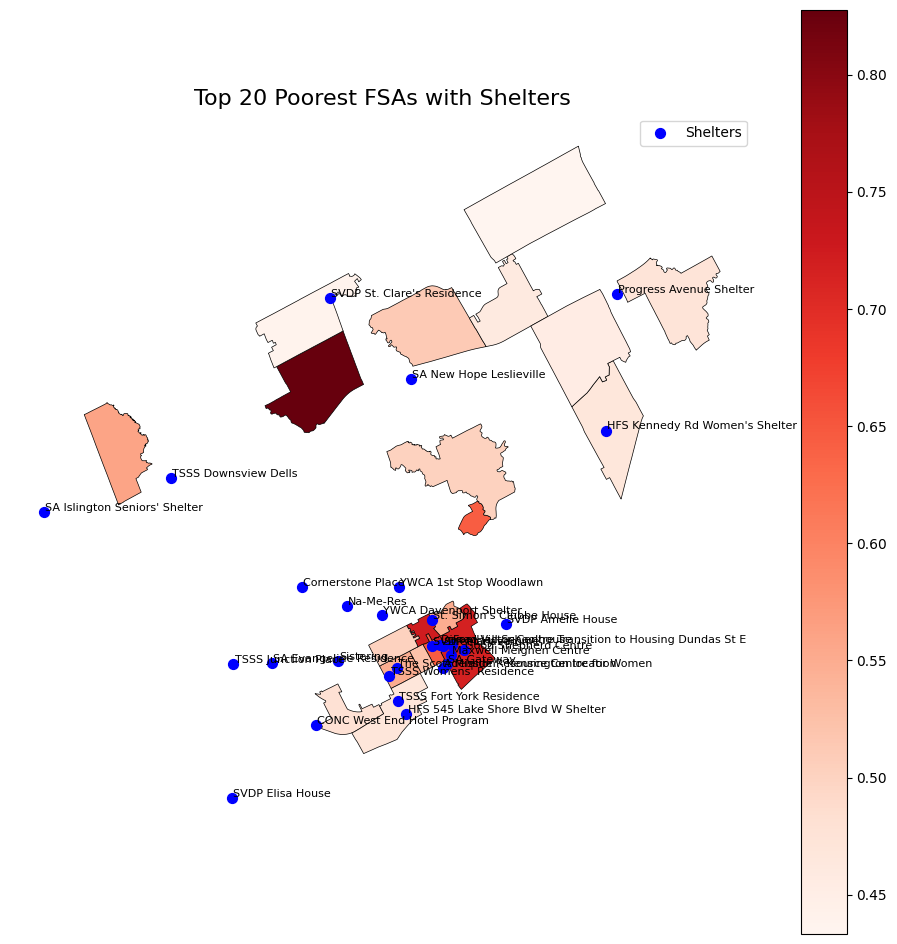

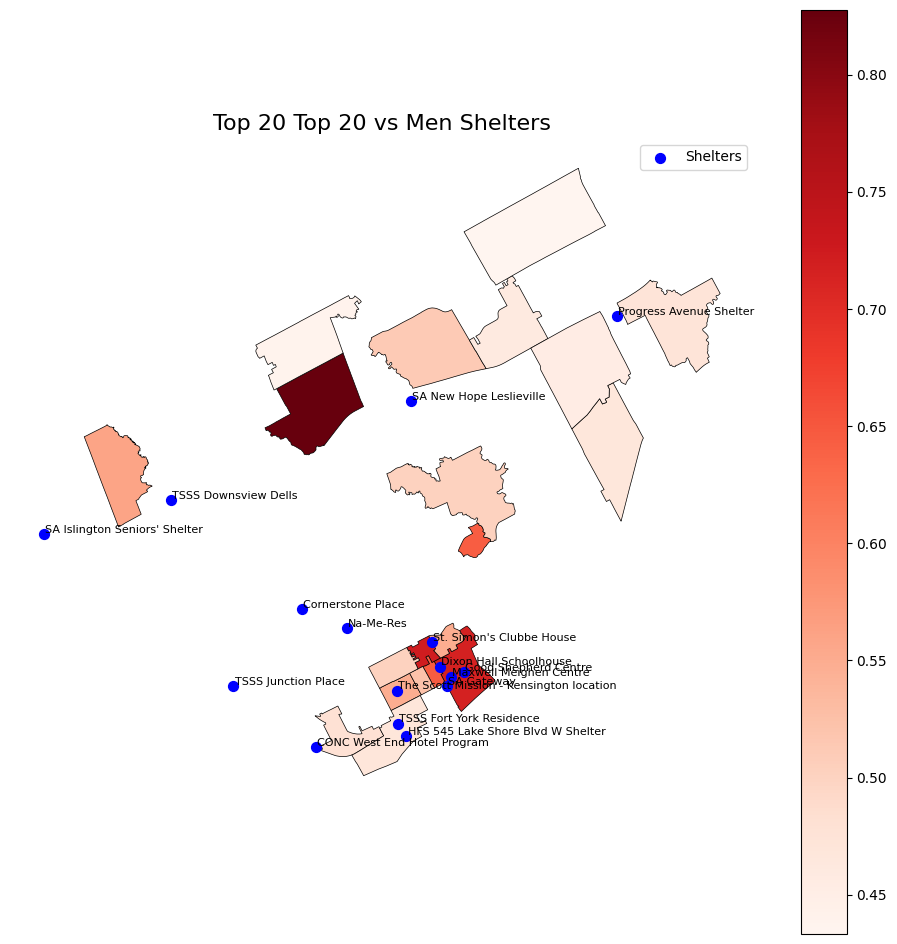

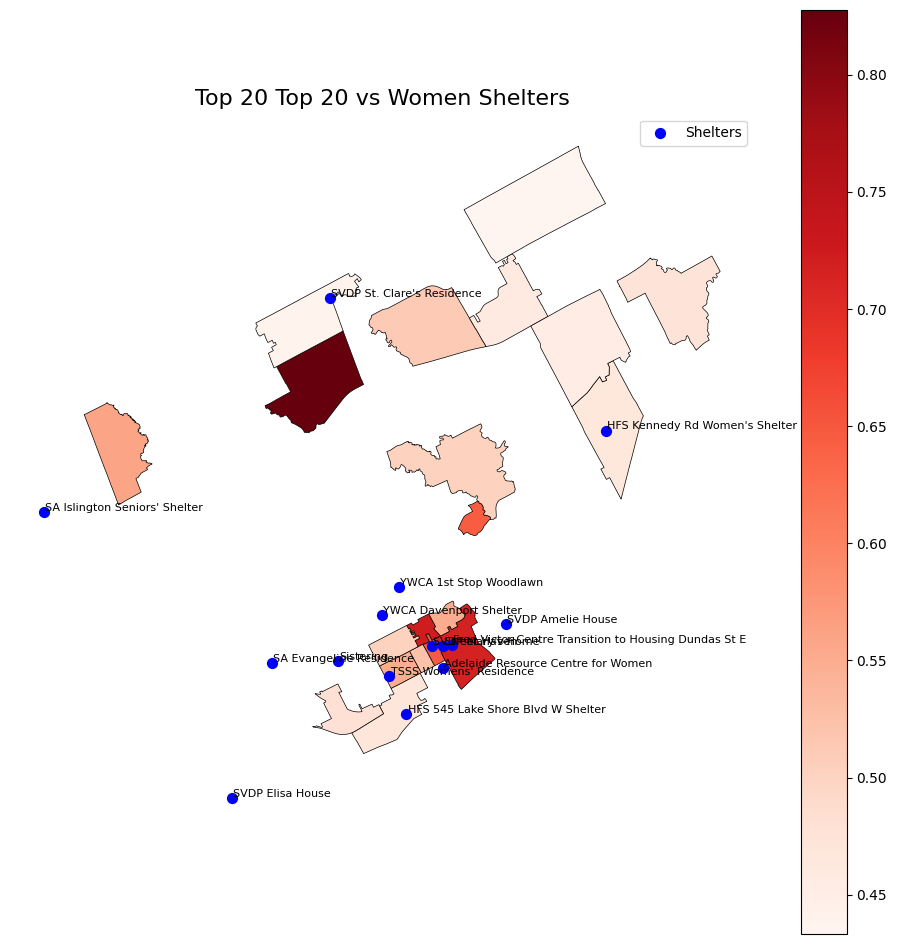

In [175]:


import geopandas as gpd
import matplotlib.pyplot as plt

def plot_fsas_and_shelters(top_k_geo, shelters, score_column='low_income_score', title = r'Poorest FSAs with Shelters'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    
    # Ensure shelters are a GeoDataFrame with same CRS as top_k_geo
    shelters_gdf = gpd.GeoDataFrame(
        shelters,
        geometry=gpd.points_from_xy(shelters['longitude'], shelters['latitude']),
        crs="EPSG:4326"  # lat/lon
    )
    shelters_gdf = shelters_gdf.to_crs(top_k_geo.crs)  # match FSA CRS
    
    # Plot FSAs
    top_k_geo.plot(
        column=score_column,
        cmap='Reds',
        linewidth=0.5,
        edgecolor='black',
        legend=True,
        ax=ax
    )
    
    # Plot shelters
    ax.scatter(
        shelters_gdf.geometry.x, 
        shelters_gdf.geometry.y, 
        color='blue', 
        s=50, 
        marker='o',
        label='Shelters'
    )
    
    # Optional: add labels for each shelter
    for idx, row in shelters_gdf.iterrows():
        ax.text(row.geometry.x + 50, row.geometry.y + 50, row['LOCATION_NAME'], fontsize=8)
    
    ax.set_title(f'Top {len(top_k_geo)} {title}', fontsize=16)

    ax.axis('off')
    ax.legend()
    plt.show()


plot_fsas_and_shelters(top_k_geo, unique_shelters, title='Poorest FSAs with Shelters')
plot_fsas_and_shelters(top_k_geo, mens_shelters, title='Top 20 vs Men Shelters')
plot_fsas_and_shelters(top_k_geo, women_shelters, title='Top 20 vs Women Shelters')



In [183]:
anyone_dist.to_csv('HELPPPP.csv')

## we have succesfullly located all these broke boys

- now imma run that LP fade

before I begin imma present what the gang came up wit


we present a 2 stage optimizaiton problem 


1) Problem 1:  minimize summation Z for wch geneder (unshletreed)
- cons1: sum of all assigned for partucalr sector + unshelted for secotr = deamns (total amount for that secotr
- cons2: the sum of all assigned for a gender r for a partucalr shelter <= capcaity for that shelter
- cons 3:  number of ppl assigend to shelter S from secotr G <= eligiblty for shelter S * demand  for geneder G


I.E. we have to craft Esg outrsleves
- 

In [178]:
! pip install CVXPY

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   ------------------------------------- -- 1.0/1.1 MB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 2.5 MB/s  0:00:00
   ---------------------------------------- 0.0/887.3 kB ? eta -:--:--
   ----------------------- ---------------- 524.3/887.3 kB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 887.3/887.3 kB 2.7 MB/s  0:00:00
   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.5 MB ? eta -:--:--
   -------- ------------------------------- 1.6/7.5 MB 4.2 MB/s eta 0:00:02
   ------------ --------------------------- 2.4/7.5 MB 4.5 MB/s eta 0:00:02
   ---------------- ----------------------- 3.1/7.5 MB 4.1 MB/s eta 0:00:02
   ---------------------- ---------------